In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Wczytywanie danych

In [88]:
database = pd.read_csv('car_prices.csv')
print(f"Rozmiar wczytanych danych:{database.shape[0]} x {database.shape[1]}")
print(database.head(5))

Rozmiar wczytanych danych:558837 x 16
   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0

# Czyszczenie danych

Ujednolicenie marek pojazdów poprzez ustawienie pierwszej litery marki na wielką oraz rozszerzenie nazw.

In [89]:
database.loc[:, 'make'] = database['make'].str.title()
database.loc[:, 'make'] = database['make'].replace({'Vw': 'Volkswagen', 'Mercedes-B':'Mercedes-Benz','Mercedes':'Mercedes-Benz','Dodge': 'Dodge Tk'})

Usunięcie wierszy zawierających wartości N/A w kolumnie 'mmr' oraz 'sellingprice'

In [90]:
database = database.dropna(subset=['make','mmr','sellingprice'],axis='rows')

# Pokazanie ilości sprzedanych pojazdów wg.marki produkcji

Na poniższym wykresie słupkowym pokazano ilość sprzedanych pojazdów pogrupowanych wg marki produkcji. Najwięcej sprzedanych aut pochodziło z takich firm jak Ford, Nissan czy Toyota.

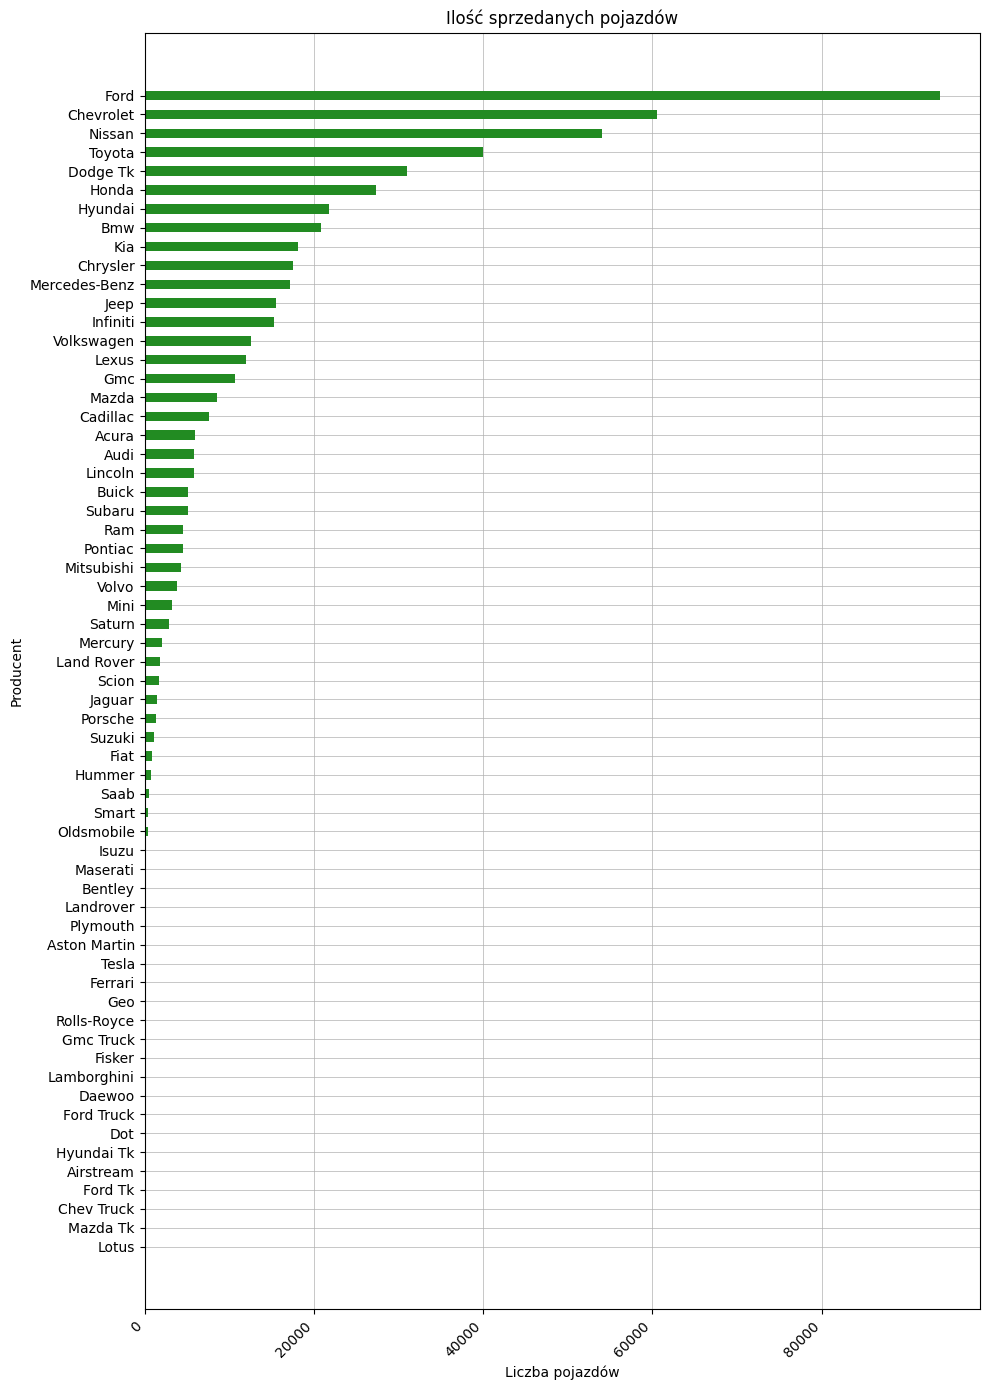

In [91]:
model_car_sum = database['make'].value_counts()
model_car_filtered = model_car_sum[model_car_sum>0]

plt.figure(figsize=(10, 14))
plt.barh(model_car_filtered.index, model_car_filtered.values, height=0.5,color='forestgreen', zorder=2)
plt.xlabel('Liczba pojazdów')
plt.ylabel('Producent')
plt.title('Ilość sprzedanych pojazdów')
plt.xticks(rotation=45, ha='right')
plt.gca().invert_yaxis()
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.tight_layout()
plt.show()

# Pokazanie rozkładu roku produkcji sprzedanych aut

Poniższy wykres przedstawia rok produkcji sprzedawanych aut. Widzimy na nim, iż ilość dokonanych transakcji jest rosnąca z wyłączeniem okresu lat 2008-2009 co pokrywa się z czasem wystąpienia wielkiego kryzysu gospodarczego.

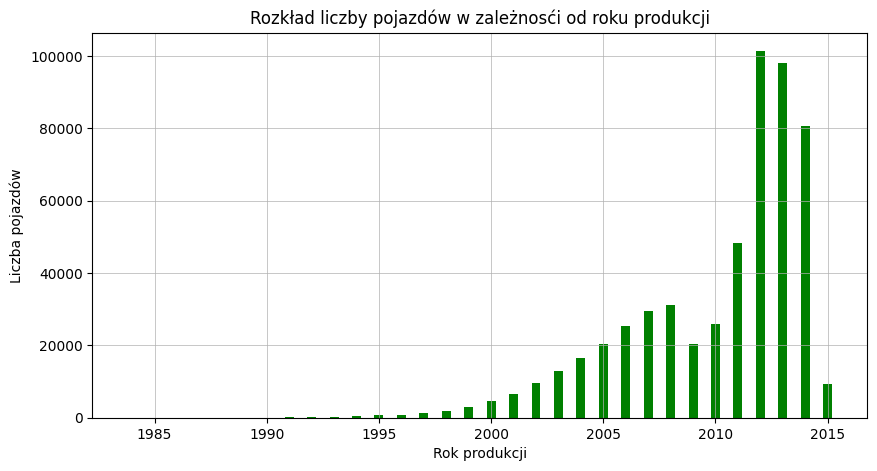

In [92]:
df_age = database['year'].value_counts()

fig = plt.figure(figsize = (10, 5))
 
years = df_age.index
counts = df_age.values

plt.bar(years, counts, color='green', width=0.4)

plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
 
plt.xlabel("Rok produkcji")
plt.ylabel("Liczba pojazdów")
plt.title("Rozkład liczby pojazdów w zależnosći od roku produkcji")
plt.show()

# Średni uśredniony przebieg pojazdu pogrupowany wg marki

Na wykresie możemy zaobserwować iż pojazdami z największym przebiegiem są te pochądzące z popularnych w USA marek jak Fors czy chevrolet. Zaś najmniejszy przebieg prezentują pojazdy z marek niszowych lub luksusowych, których pojazdy nie są wykorzystywane jako narzędzie pracy.

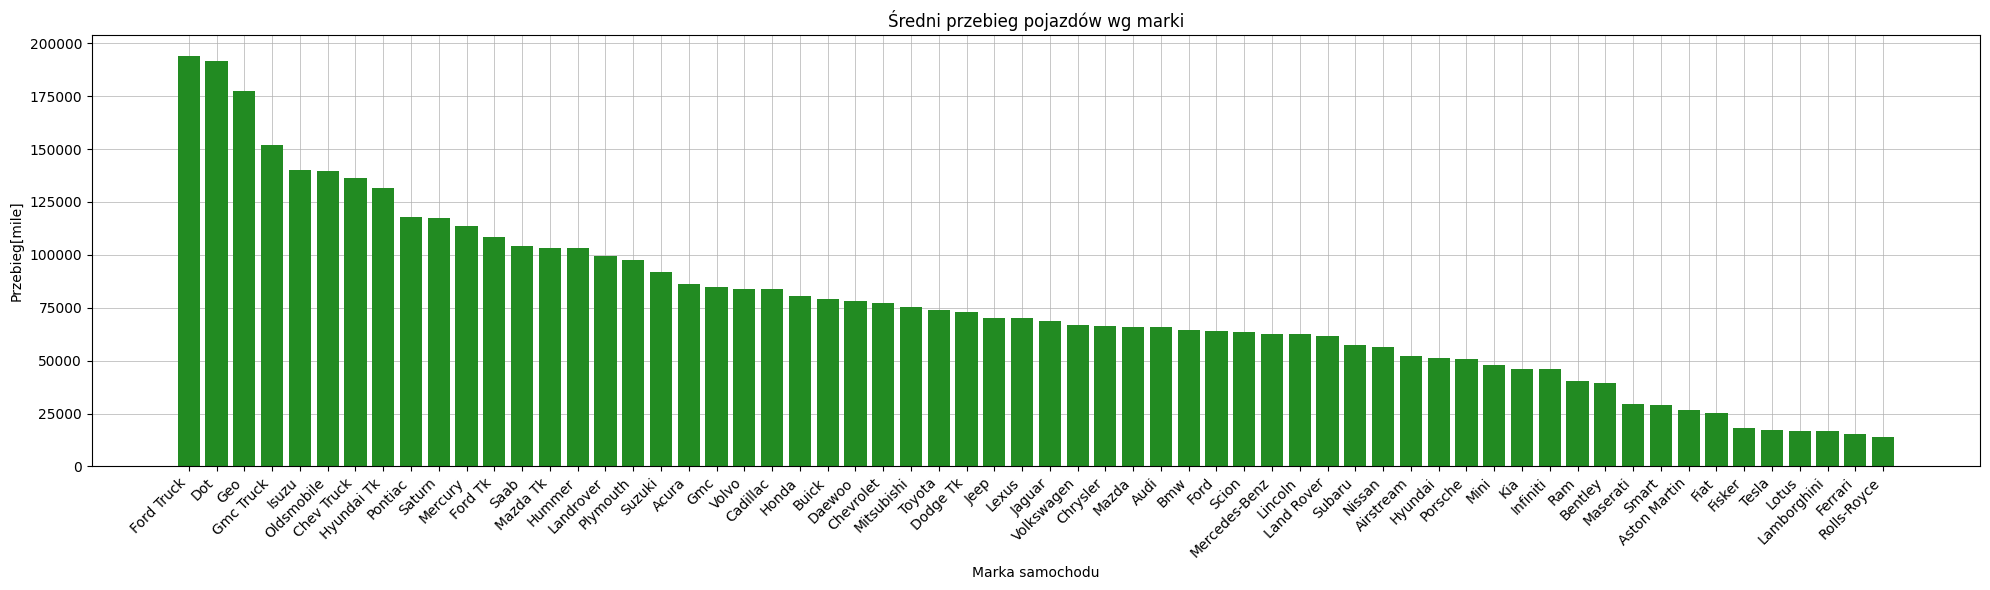

In [93]:
mean_odometer = database.groupby('make')['odometer'].mean()
mean_odometer_sorted = mean_odometer.sort_values(ascending=False)

plt.figure(figsize=(20, 6))
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.bar(mean_odometer_sorted.index, mean_odometer_sorted.values, color='forestgreen', zorder=2)
plt.xlabel('Marka samochodu')
plt.ylabel('Przebieg[mile]')
plt.title('Średni przebieg pojazdów wg marki')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Średni wiek pojazdu

Uśredniony rok produkcji samochodu(na podstawie wszystkich wpisów dla poszczególnej marki) pogrupowanych według marki pojazdu. Widać na nim, iż najmłodzsze pojazdy pochodzą z fabryki Tesli, zaś najstarszymi jednostkami w użyciu są np. Fordy.

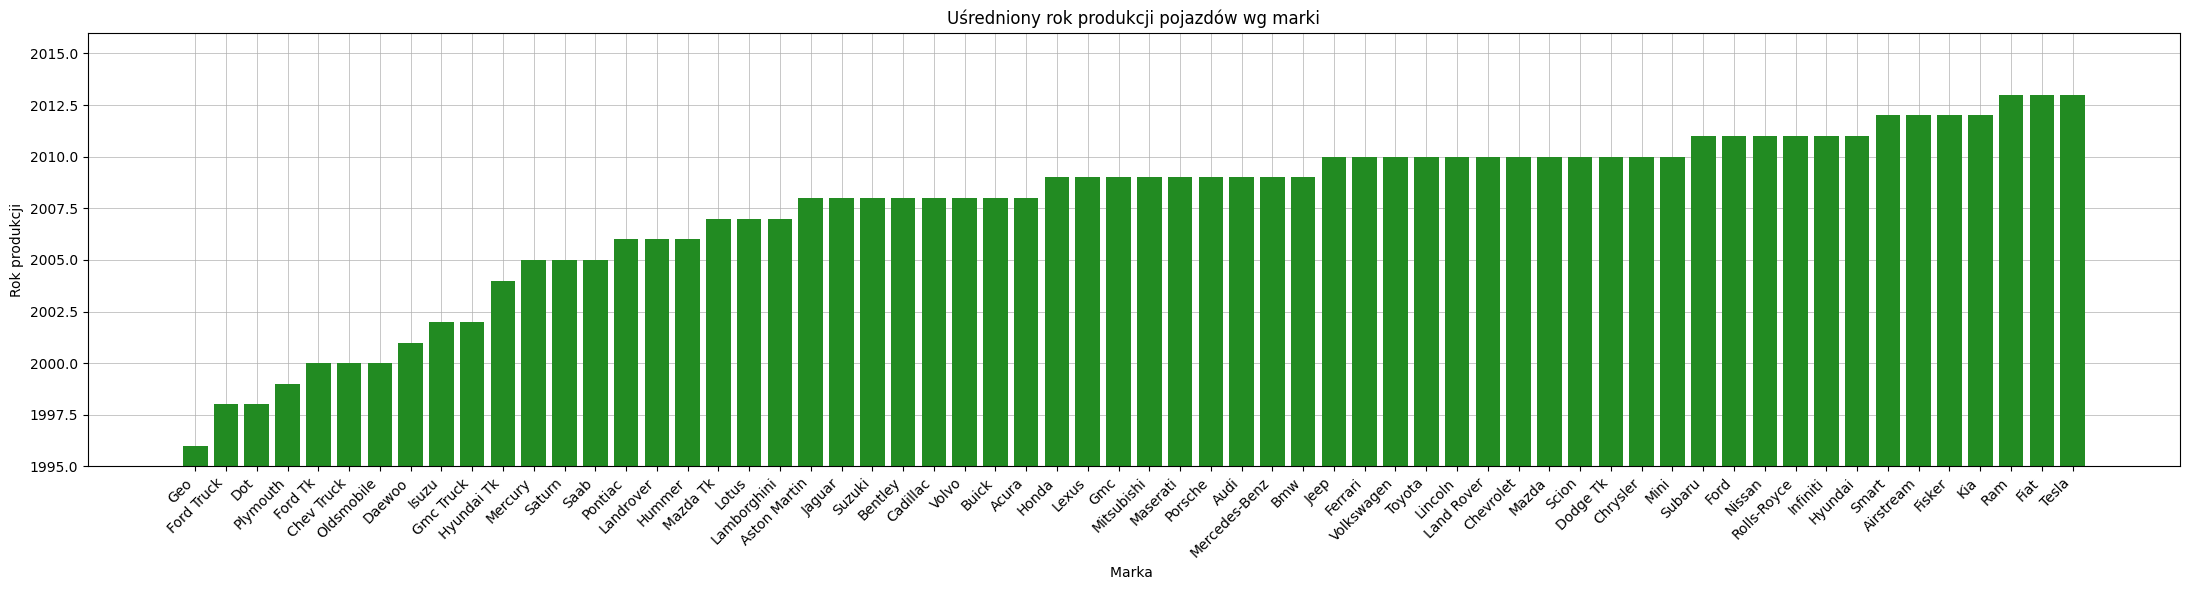

In [94]:

mean_age = database.groupby('make')['year'].mean()
mean_age_sorted = mean_age.sort_values(ascending=True).round().astype(int)


plt.figure(figsize=(22, 6))
plt.bar(mean_age_sorted.index, mean_age_sorted.values, color='forestgreen', zorder=2)
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.xlabel('Marka ')
plt.ylabel('Rok produkcji')
plt.title('Uśredniony rok produkcji pojazdów wg marki')
plt.xticks(rotation=45, ha='right')
plt.ylim(1995, 2016)
plt.tight_layout()
plt.show()

# Średnia cena pojazdu wg marki

Średnia cena pojazdów w zależności od marki. Najdroższą marką jest Rolls-Royce, który wyprzedził w tym zestawieniu Ferrari.

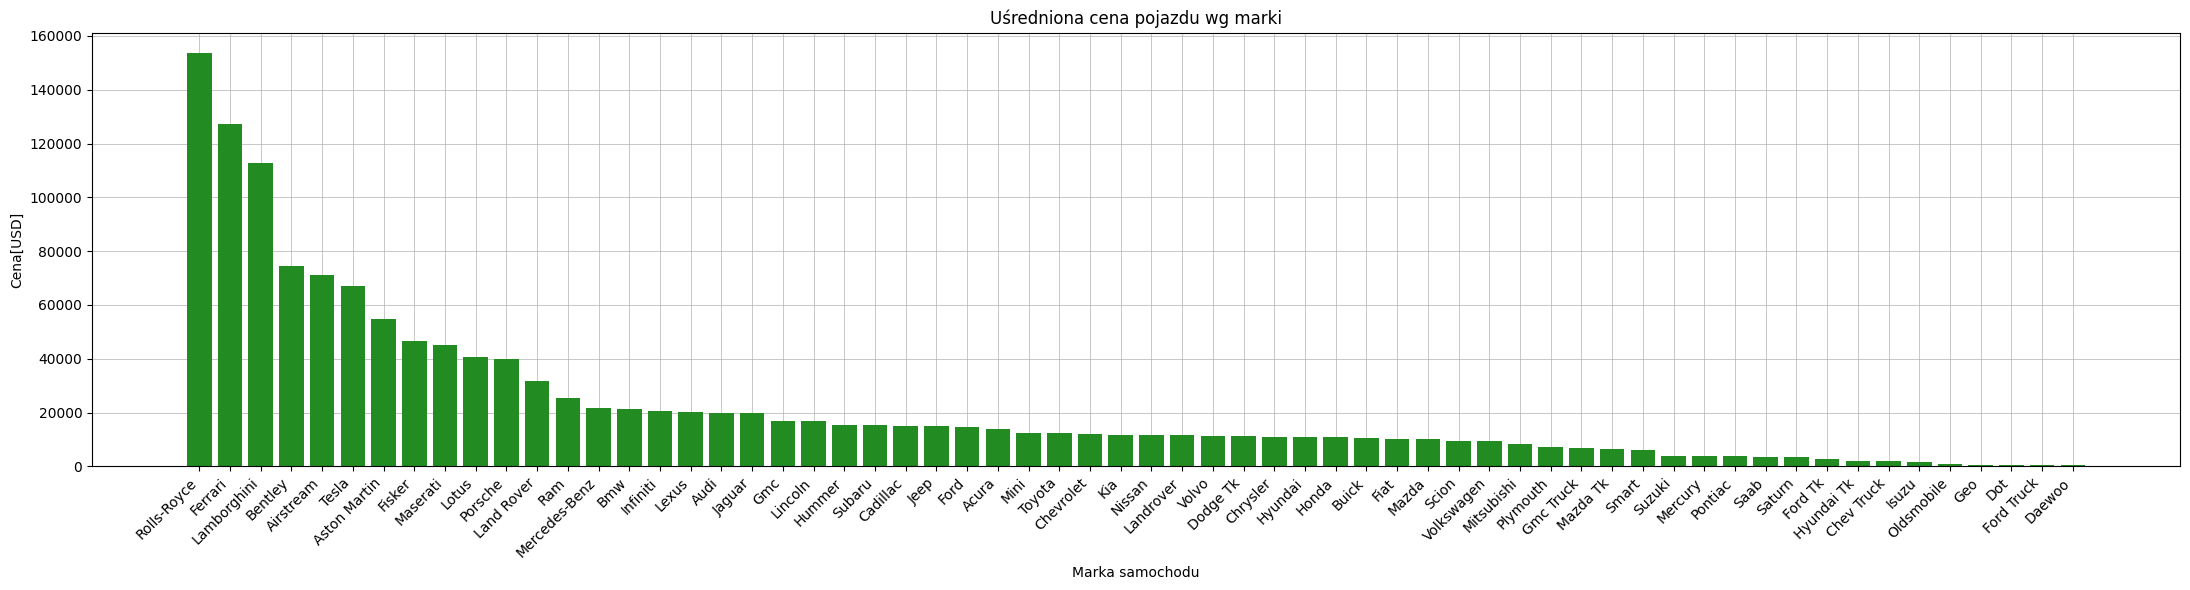

In [95]:
mean_price = database.groupby('make')['sellingprice'].mean()
mean_price_sorted = mean_price.sort_values(ascending=False).round().astype(int)


plt.figure(figsize=(22, 6))
plt.bar(mean_price_sorted.index, mean_price_sorted.values, color='forestgreen', zorder=2)
plt.grid(True,which='both',axis='both' , zorder=0, linewidth=0.5)
plt.xlabel('Marka samochodu')
plt.ylabel('Cena[USD]')
plt.title('Uśredniona cena pojazdu wg marki')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 10 najdroższych marek pojazdów wraz z 5 najcenniejszymi modelami

Poniższy wykres przedstawia 10 marek, których cena sprzedanych pojazdów była największa. Poszczególne wykresy prezentują od jednego do 5 modeli pojazdów, które zostały sprzedane. Bezpośrednio na wykresie widzimy  średnią cenę oraz model samochodu. Ponownie pojazdy marki Rolls-Royce okazały się najdroższymi, a zestawienie zamyka firma Porsche ze swoimi modelami.

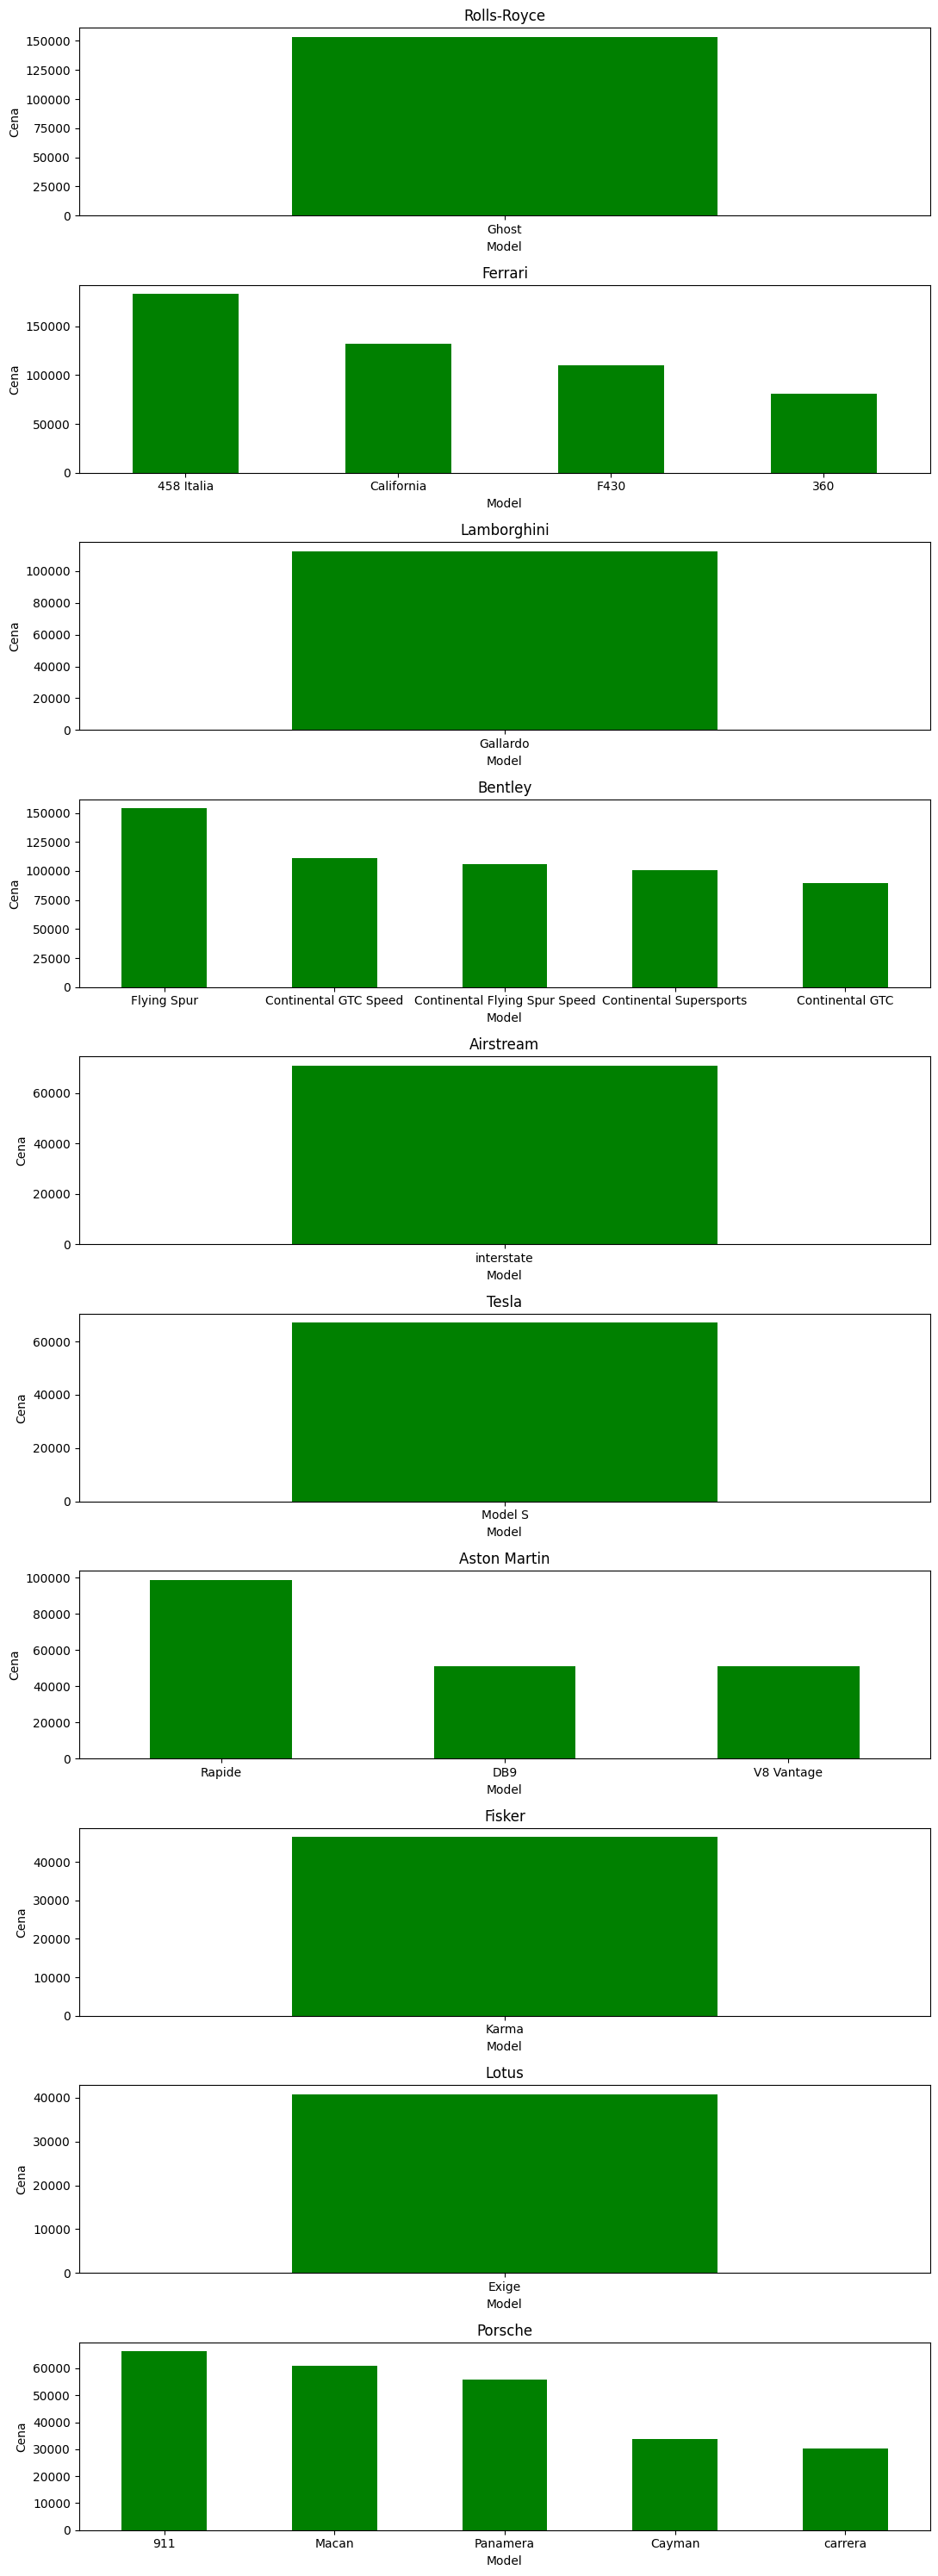

In [96]:
average_prices = database.groupby(['make', 'model'])['sellingprice'].mean()

top_makes = average_prices.groupby('make').mean().nlargest(10)

fig, axes = plt.subplots(nrows=len(top_makes), ncols=1, figsize=(11, 3 * len(top_makes)))

for i, (make, avg_price) in enumerate(top_makes.items()):
    top_models = average_prices.loc[make].nlargest(5)
    
    top_models.plot(kind='bar', ax=axes[i], color='green')
    
    axes[i].set_title(make)
    axes[i].set_ylabel('Cena')
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# Regresja liniowa kwoty wyceny i sprzedaży auta

Każdy z punktów prezentuje cenę pojazdu w momencie wyceny oraz sprzedaży. Większość z nich położona jest wzdłuż wyznaczonej linii, oznaczająćej że obydwie kwoty są takie same. Im niższa była wartość pojazdu, tym różnica pomiędzy tymi dwiema wartościami była większa. Wystąpiły również przypadki, gdzie cena wyceny a sprzedaży różniły się w znacznym stopniu. 

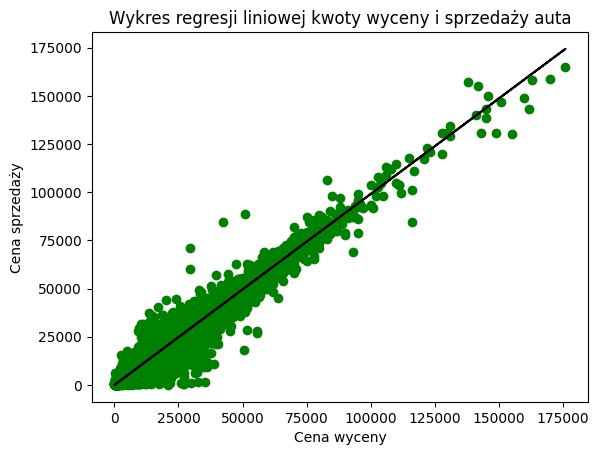

In [97]:
data = database.dropna(axis='rows', subset=['mmr', 'sellingprice', 'make'])

X = data['mmr'].values.reshape(-1,1)
y = data['sellingprice']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 1410)

reg = LinearRegression().fit(X_train, y_train)
res = reg.score(X_test, y_test)

y_pred = reg.predict(X_test)
plt.scatter(X_test, y_test, color ='green')
plt.plot(X_test, y_pred, color ='k')
plt.title('Wykres regresji liniowej kwoty wyceny i sprzedaży auta')

plt.xlabel('Cena wyceny')
plt.ylabel('Cena sprzedaży')
 
plt.show()



# Korelacja pomiędzy poszczególnymi rodzajami danych

Korelacja pozwala na określenie wzajemnego powiązania pomiędzy wybranymi zmiennymi. Najbardziej powiązanymi zmiennymi był cena sprzedaży(sellingprice) oraz cena wyceny pojazdu(mmr).

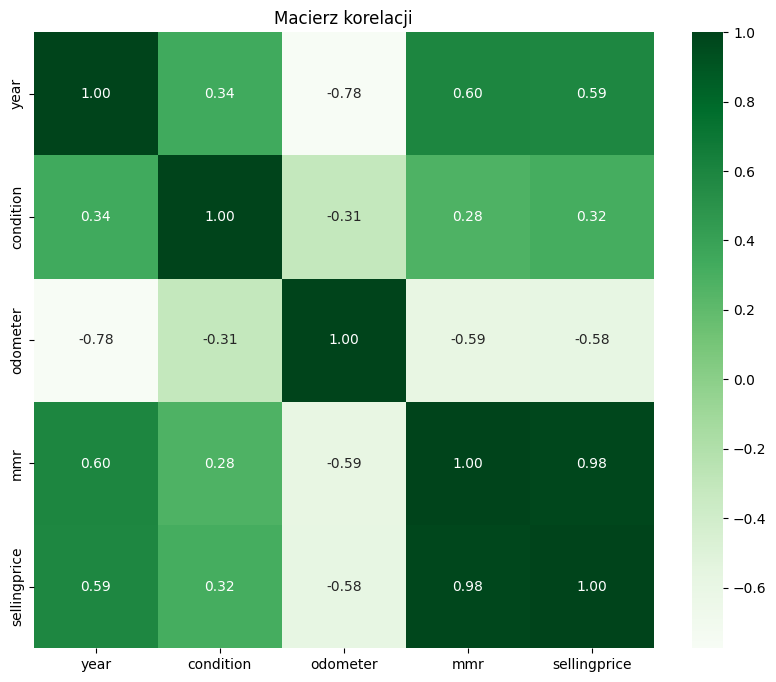

In [98]:
import pandas as pd

data_corr = pd.DataFrame(database)

numeric_data = data_corr.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")

plt.title('Macierz korelacji')

plt.show()

# Predykcja ceny sprzedaży samochodów marki BMW w zależnośći od roku produkcji wykonana za pomocą algorytmu Drzew decyzyjnych

In [99]:
data_bmw_price = data.copy()
data_bmw = data_bmw_price[data_bmw_price['make'] == 'Bmw']

X = data_bmw['year']
y = data_bmw['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

In [100]:
data_bmw_price = data.copy()
data_bmw = data_bmw_price[data_bmw_price['make'] == 'Bmw']

X = data_bmw['year']
y = data_bmw['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
tree_model = DecisionTreeRegressor(random_state=1410)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
print('X_test:',X_test.shape)
print('y_pred:',y_pred.shape)
tree_metric = mean_absolute_percentage_error(y_test, y_pred)
print(tree_metric)

X_test: (4159, 1)
y_pred: (4159,)
0.3033704651054402


Prezentacja uzyskanych wyników za pomocą wykresu

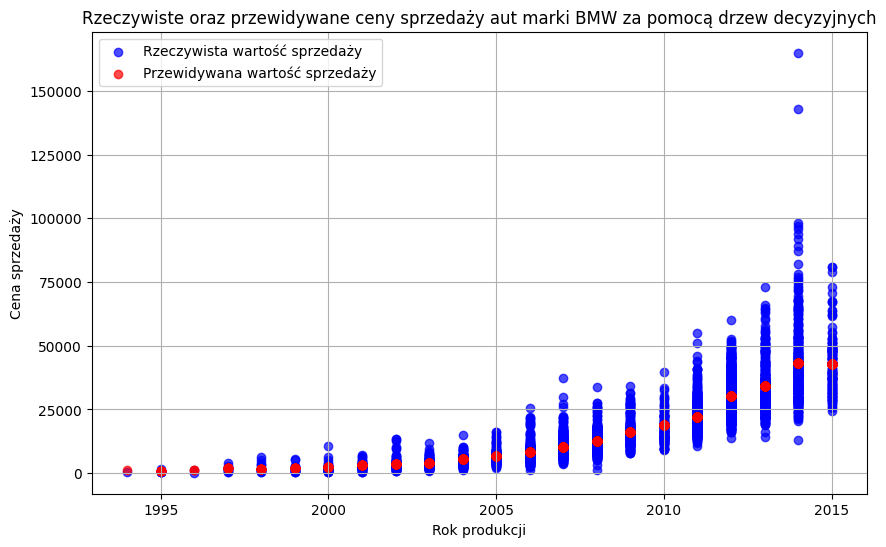

In [101]:
plt.figure(figsize=(10, 6))

plt.scatter(X_test, y_test, label='Rzeczywista wartość sprzedaży', color='blue', alpha=0.7)
plt.scatter(X_test, y_pred, label='Przewidywana wartość sprzedaży', color='red', alpha=0.7)

plt.title('Rzeczywiste oraz przewidywane ceny sprzedaży aut marki BMW za pomocą drzew decyzyjnych')
plt.xlabel('Rok produkcji')
plt.ylabel('Cena sprzedaży')
plt.legend()
plt.grid()
plt.show()

Prezentacja uzyskanych wyników za pomocą wykresu wykorzystującego uśrednianie danych po ich grupowaniu(współczynnik grupowania równy 100)

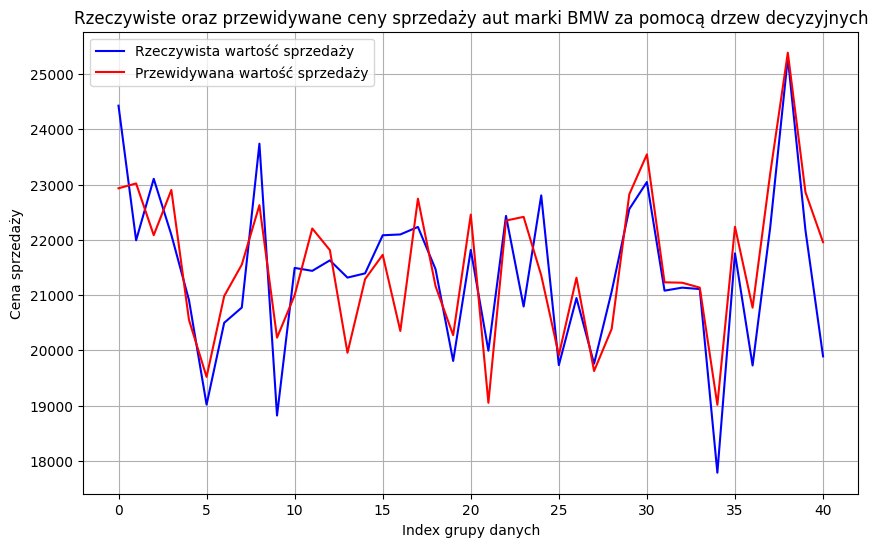

Mean Absolute Error (MAE): 4992.82


In [102]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

y_test_avg = y_test.groupby(y_test.index // 10).mean()
y_pred_avg = pd.Series(y_pred).groupby(pd.Series(y_pred).index // 10).mean()
bins = np.arange(0, len(y_test) + 1, 100)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Rzeczywista wartość sprzedaży', color='blue')
plt.plot(y_pred_binned_avg, label='Przewidywana wartość sprzedaży', color='red')
plt.xlabel('Index grupy danych')
plt.ylabel('Cena sprzedaży')
plt.title('Rzeczywiste oraz przewidywane ceny sprzedaży aut marki BMW za pomocą drzew decyzyjnych')
plt.legend()
plt.grid()

plt.show()

mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))

# Predykcja ceny sprzedaży samochodów marki BMW w zależnośći od roku produkcji wykonana za pomocą algorytmu KNN

In [103]:
X = data_bmw['year']
y = data_bmw['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))

Mean Absolute Error (MAE): 5034.27


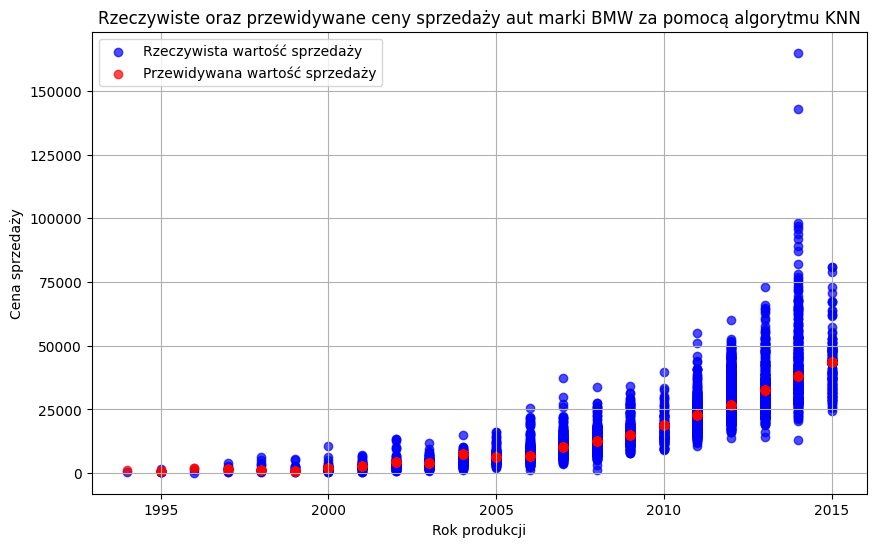

In [104]:
plt.figure(figsize=(10, 6))

plt.scatter(X_test, y_test, label='Rzeczywista wartość sprzedaży', color='blue', alpha=0.7)
plt.scatter(X_test, y_pred, label='Przewidywana wartość sprzedaży', color='red', alpha=0.7)

plt.title('Rzeczywiste oraz przewidywane ceny sprzedaży aut marki BMW za pomocą algorytmu KNN')
plt.xlabel('Rok produkcji')
plt.ylabel('Cena sprzedaży')
plt.legend()
plt.grid()
plt.show()

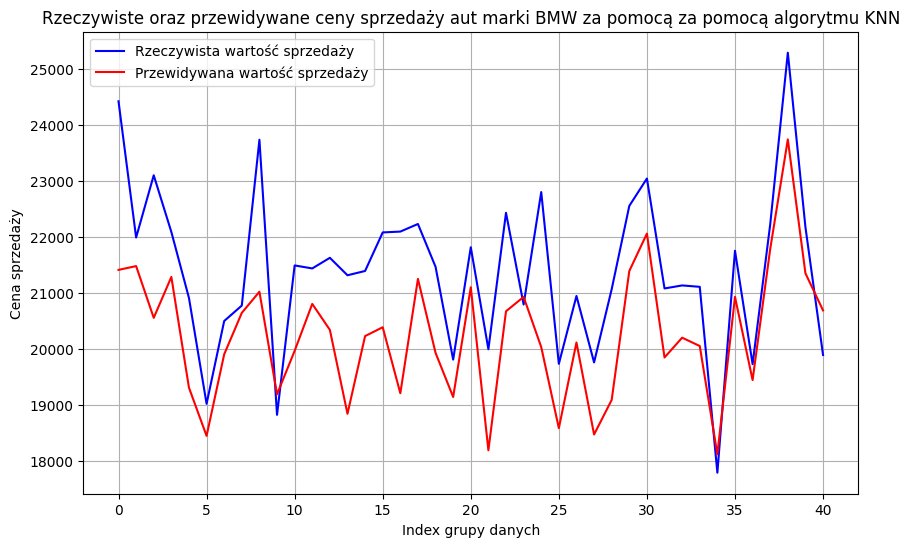

Mean Absolute Error (MAE): 5034.27


In [105]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

y_test_avg = y_test.groupby(y_test.index // 10).mean()
y_pred_avg = pd.Series(y_pred).groupby(pd.Series(y_pred).index // 10).mean()
bins = np.arange(0, len(y_test) + 1, 100)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Rzeczywista wartość sprzedaży', color='blue')
plt.plot(y_pred_binned_avg, label='Przewidywana wartość sprzedaży', color='red')
plt.xlabel('Index grupy danych')
plt.ylabel('Cena sprzedaży')
plt.title('Rzeczywiste oraz przewidywane ceny sprzedaży aut marki BMW za pomocą za pomocą algorytmu KNN')
plt.legend()
plt.grid()

plt.show()

mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))

# Predykcja ceny sprzedaży samochodów wykonana za pomocą algorytmu Drzew decyzyjnych

W celu predykcji ceny sprzedaży samochodu wykorzystane zostały dane z kolumny 'sellingprice' oraz 'make'. Ze względu na afkt, iż kolumna 'make' posiada informacje w postaci nazw marek, użyto OneHotEncodera do wyznaczenia indeksów. Następnie za pomocą regresora drzewa decyzyjnego dokonano predykcji ceny sprzedaży, a na wykresie przedstawiono rzeczywiste oraz przewidywane wartośći. Ze względu na dużą ilość próbek do umożliwienia czytelnej prezentacji rezultatów wykorzystano grupowanie danych na wykresach.

In [ ]:
data_Tree_price = data.copy()

X = data_Tree_price['make']
y = data_Tree_price['sellingprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

X_2d = X.values.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
X_encoded = encoder.fit_transform(X_2d)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=1410)
tree_model = DecisionTreeRegressor(random_state=1410)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
tree_metric = mean_absolute_percentage_error(y_test, y_pred)

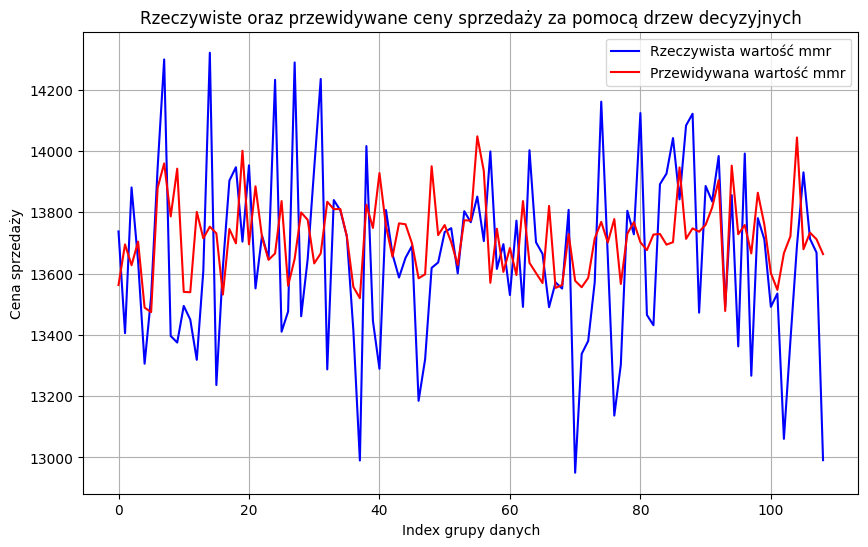

In [107]:




result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

y_test_avg = y_test.groupby(y_test.index // 10).mean()
y_pred_avg = pd.Series(y_pred).groupby(pd.Series(y_pred).index // 10).mean()
bins = np.arange(0, len(y_test) + 1, 1000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Przewidywana wartość mmr', color='red')
plt.xlabel('Index grupy danych')
plt.ylabel('Cena sprzedaży')
plt.title('Rzeczywiste oraz przewidywane ceny sprzedaży za pomocą drzew decyzyjnych')
plt.legend()
plt.grid()

plt.show()



Następnie na podstawie stworzonego modelu dokonano jego oceny za pomocą metryki MAE, czyli błędu średniokwadratowego. Uzyskany rezultat wynosi ponad 6 tysięcy, co oznacza że jakość modelu nie jest na najwyższym poziomie.

In [108]:
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))

Mean Absolute Error (MAE): 6327.53


# Predykcja ceny MMR sprzedaży samochodów wykonana za pomocą algorytmu Drzew decyzyjnych

MMR - To narzędzie, które śledzi ceny samochodów na rynku wtórnym. To przydatne narzędzie dla dealerów samochodowych, kupujących i sprzedających, ponieważ dostarcza aktualnych informacji na temat wartości rynkowej różnych modeli samochodów. MMR zbiera dane z transakcji na aukcjach samochodowych oraz innych źródeł, aby określić przeciętne ceny pojazdów i trendów cenowych. W tym przypadku również skorzystano z regresora drzew decyzyjnych, jednakże jako One Hot Encoder wykorzystano wbudowaną funkcję biblioteki pandas.

In [109]:
data_Tree = data.copy()

X = pd.get_dummies(data_Tree['make'])
y = data_Tree['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)
tree_model = DecisionTreeRegressor(random_state=1410)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))


Mean Absolute Error (MAE): 6230.78


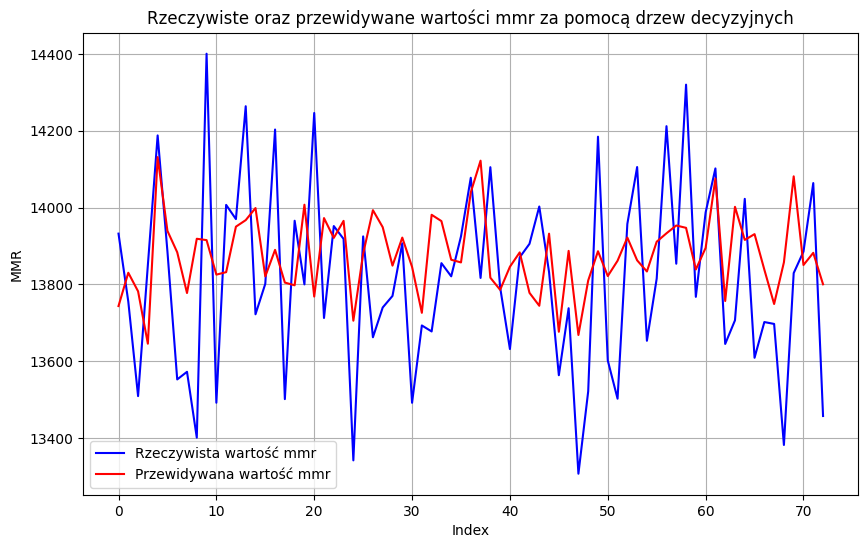

In [110]:
bins = np.arange(0, len(y_test) + 1, 1500)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('MMR')
plt.title('Rzeczywiste oraz przewidywane wartości mmr za pomocą drzew decyzyjnych')
plt.legend()
plt.grid()

plt.show()

In [111]:
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))

Mean Absolute Error (MAE): 6230.78


# Predykcja ceny MMR sprzedaży samochodów wykonana za pomocą algorytmu MLP

In [ ]:

data_MLP = data.copy()

X = pd.get_dummies(data_MLP['make'])
y = data_MLP['mmr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1410)

mlp_model = MLPRegressor(hidden_layer_sizes=10)
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))


result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

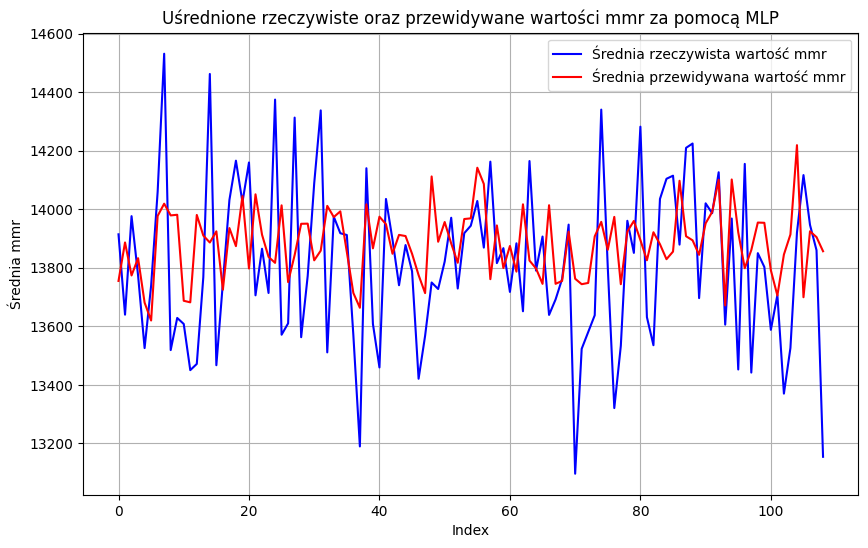

In [113]:
bins = np.arange(0, len(y_test) + 1, 1000)

y_test_binned_avg = [y_test.iloc[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]
y_pred_binned_avg = [y_pred[bins[i]:bins[i+1]].mean() for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))

plt.plot(y_test_binned_avg, label='Średnia rzeczywista wartość mmr', color='blue')
plt.plot(y_pred_binned_avg, label='Średnia przewidywana wartość mmr', color='red')


plt.xlabel('Index')
plt.ylabel('Średnia mmr')
plt.title('Uśrednione rzeczywiste oraz przewidywane wartości mmr za pomocą MLP')
plt.legend()
plt.grid()

plt.show()

In [114]:
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))

Mean Absolute Error (MAE): 6243.57


# Podsumowanie

W pierwszej części analizy danych przedstawiono otrzymane dane po oczyszczeniu za pomocą różnego rodzaju wykresów pokazujących np. rozkład cen pojazdów w zależności od roku produkcji, ceny sprzedaży czy najdroższe modele pojazdów. Druga część analizy skupiła się na wykorzystaniu różnych regresorów w celu predykcji np. ceny wylicznej przez oprogramowanie MMR. W tym celu wykorzystano różne algorytmy takie jak Drzewa decyzyjne czy MLP. Uzyskane rezultaty oceniono za pomocą metryki MAE, która mierzy średnią wartość błędu pomiędzy wartością przewidywaną, a rzeczywistą. Uzyskane wartości niestety były znaczne, co oznacza że jakość predykcji nie była na najwyższym poziomie. Wpływ na to miała duża różnorodność wartości danych w zbiorze przy niezbyt wielkim jego rozmiarze. Mimo tego na przedstawionych wykresach widać, że wartości przewidywane były zbliżone do oryginalnych.
